# Text Mining for Stock Market Prediction
<br> </br>

In this notebook we will run the definitive BERT model for stock market prediction based on SEC filings. In this implementation we will use the original BERT model (bert-base-uncased).

In [ ]:
!pip install tf-models-official==2.4.0
!pip install tensorflow_hub
!pip install keras tf-models-official pydot graphviz

import os

import numpy as np
import pandas as pd

import torch
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns


## Importing dataset

In [ ]:
df = pd.read_csv('/content/final_consolidated_data.txt')
df.head()

,Unnamed: 0,CIK Code,Filing,Date Filed,Ticker,CompanyName,PrevAvgPriceChange,PostAvgPriceChange,Label
0,0,1680378,Investing in ourshares of common stock involve...,2021-03-18,SNES,"SenesTech, Inc.",0.001328,-0.003177,neutral
1,1,1222719,Investing in any of our securities involves ri...,2021-01-31,CHY,CALAMOS CONVERTIBLE & HIGH INCOME FUND,0.004126,0.006552,neutral
2,2,1364954,An investment in our securities involves a hig...,2021-04-03,CHGG,"CHEGG, INC",0.065078,0.011987,neutral
3,3,1674930,Investing in our common stock involves risk. B...,2020-08-12,FLGT,"Fulgent Genetics, Inc.",0.412805,0.058477,neutral
4,4,1409375,Investing in our common stock involves a high ...,2021-03-10,OESX,"ORION ENERGY SYSTEMS, INC.",-0.046603,-0.002521,increase


In [ ]:
df.drop(columns = 'Unnamed: 0', inplace = True)
df.head()

,CIK Code,Filing,Date Filed,Ticker,CompanyName,PrevAvgPriceChange,PostAvgPriceChange,Label
0,1680378,Investing in ourshares of common stock involve...,2021-03-18,SNES,"SenesTech, Inc.",0.001328,-0.003177,neutral
1,1222719,Investing in any of our securities involves ri...,2021-01-31,CHY,CALAMOS CONVERTIBLE & HIGH INCOME FUND,0.004126,0.006552,neutral
2,1364954,An investment in our securities involves a hig...,2021-04-03,CHGG,"CHEGG, INC",0.065078,0.011987,neutral
3,1674930,Investing in our common stock involves risk. B...,2020-08-12,FLGT,"Fulgent Genetics, Inc.",0.412805,0.058477,neutral
4,1409375,Investing in our common stock involves a high ...,2021-03-10,OESX,"ORION ENERGY SYSTEMS, INC.",-0.046603,-0.002521,increase


In [ ]:
df.dropna(axis = 0, how = 'any', inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1350 entries, 0 to 1352
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CIK Code            1350 non-null   int64  
 1   Filing              1350 non-null   object 
 2   Date Filed          1350 non-null   object 
 3   Ticker              1350 non-null   object 
 4   CompanyName         1350 non-null   object 
 5   PrevAvgPriceChange  1350 non-null   float64
 6   PostAvgPriceChange  1350 non-null   float64
 7   Label               1350 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 94.9+ KB


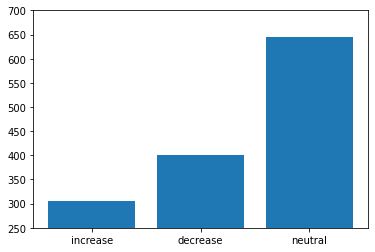

Price increased: 306 times
Price decreased: 400 times
Price did not move: 644 times


In [ ]:
incr_counts = 0
decr_counts = 0
neutral_counts = 0

for i in df.Label:
  if i == 'increase':
    incr_counts += 1
  elif i == 'decrease':
    decr_counts += 1

neutral_counts = len(df) - (incr_counts + decr_counts)
counts = [incr_counts, decr_counts, neutral_counts]
labels = ['increase', 'decrease', 'neutral']

plt.bar(labels, counts)
plt.ylim([250,700])
plt.show()

print('Price increased: {} times'.format(incr_counts))
print('Price decreased: {} times'.format(decr_counts))
print('Price did not move: {} times'.format(neutral_counts))

Since the dataset is pretty unbalanced we should evaluate the AUC.

## Connecting to cloud hardware

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
  print('Found GPU at: {}'.format(device_name))
else:
  raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print('There are %d GPU(s) available' % torch.cuda.device_count())
  print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
  print('No GPU available, using CPU')
  device = torch.device("cpu")

There are 1 GPU(s) available
We will use the GPU: Tesla K80


##Train/test splitting

In [ ]:
x = df.Filing.values
y = df.Label.values
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)

## Label encoding

In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

In [ ]:
max_seq_length = 200

## Tokenization

In [ ]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
def encode_names(n, tokenizer):
  tokens = list(tokenizer.tokenize(n))
  #tokens.append('[SEP]')
  return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

We already tokenized each filing, but now we are going to split each filing into blocks of 200 tokens. We are then going to feed each subblock into BERT and use mean pooling to get the final prediction of the label. 

In [ ]:
X_train = bert_encode(x_train, tokenizer, 200)
X_test = bert_encode(x_test, tokenizer, 200)

## Training

In [ ]:
num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

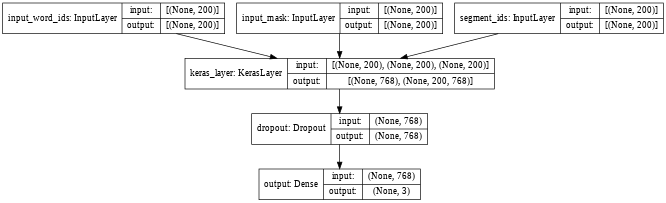

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [ ]:
#training parameters
epochs = 3
batch_size = 16  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy', 
                       tf.keras.metrics.AUC(multi_label=True)])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 200)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 200)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [ ]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/3
68/68 [==============================] - 121s 1s/step - loss: 1.0417 - categorical_accuracy: 0.4701 - auc: 0.6020 - val_loss: 0.8719 - val_categorical_accuracy: 0.6333 - val_auc: 0.7647
Epoch 2/3
68/68 [==============================] - 98s 1s/step - loss: 0.8517 - categorical_accuracy: 0.6626 - auc: 0.7604 - val_loss: 0.8202 - val_categorical_accuracy: 0.6630 - val_auc: 0.7731
Epoch 3/3
68/68 [==============================] - 98s 1s/step - loss: 0.7872 - categorical_accuracy: 0.6727 - auc: 0.8134 - val_loss: 0.7750 - val_categorical_accuracy: 0.6926 - val_auc: 0.7991


In [ ]:
loss, accuracy, auc = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy, auc = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7083
Testing Accuracy:  0.6926


In [ ]:
def plot_history(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

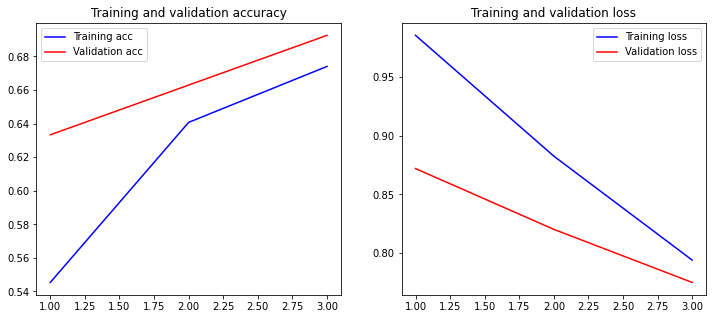

In [ ]:
plot_history(history)

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import sklearn.metrics as metrics

In [ ]:
model_fname = 'final_BERT'
my_wd = '/content/drive/My Drive/YouTube/botters_2020-10/twitter_sentiment_course/'

model.save(os.path.join(my_wd, model_fname))

In [ ]:
def multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17,6)):
  y_score = clf.predict(X_test)

  fpr = {}
  tpr = {}
  roc_auc = {}

  y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:,1], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  fig,ax = plt.subplots(figsize=figsize)
  ax.plot([0,1], [0,1], 'k--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False positive rate')
  ax.set_ylabel('True positive rate')
  ax.set_title('ROC')
  for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], label = 'ROC curve (area=%0.2f) for label %i' % (roc_auc[i], i))
  ax.legend(loc='best')
  ax.grid(alpha=.4)
  sns.despine()
  plt.show()

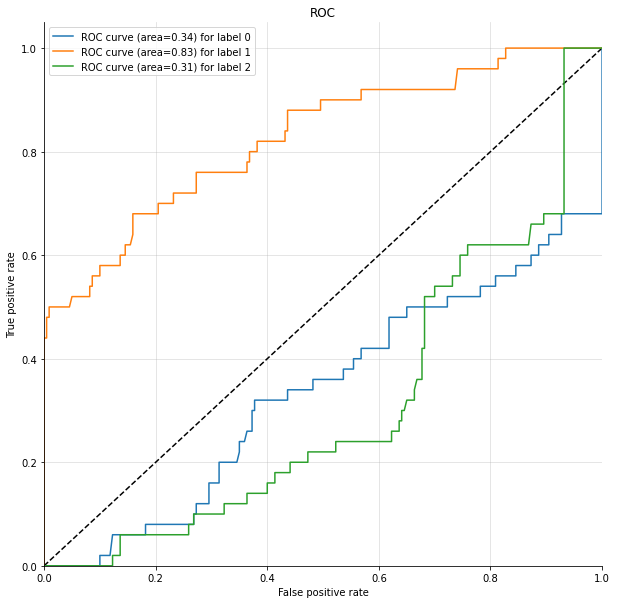

In [ ]:
multiclass_roc(model, X_test, y_test, n_classes = 3, figsize = (10,10))
# we can take the weighted AUC

In [ ]:
import keras.backend as K
def f1_weighted(true, pred): 

    predLabels = K.argmax(pred, axis=-1)
    pred = K.one_hot(predLabels, 3) 


    ground_positives = K.sum(true, axis=0) + K.epsilon()       
    pred_positives = K.sum(pred, axis=0) + K.epsilon()         
    true_positives = K.sum(true * pred, axis=0) + K.epsilon()  
        
    
    precision = true_positives / pred_positives 
    recall = true_positives / ground_positives
        
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
        

    weighted_f1 = f1 * ground_positives / K.sum(ground_positives) 
    weighted_f1 = K.sum(weighted_f1)

    
    return weighted_f1 #if loss, return 1 - weighted_f1

In [ ]:
f1_weighted(dummy_y_test, model.predict(X_test))

<tf.Tensor: shape=(), dtype=float32, numpy=0.6879103>